# Heating Analysis

##### A GWDST project to investigate heating distributions in space and time, along with investigations of variability

### Input and data

In [1]:
%matplotlib inline

from glob import glob
import numpy as np
import pandas as pd
import xarray as xr
import xarray.ufuncs as xu
import matplotlib.pyplot as plt
import seaborn as sns
#import cartopy.crs as ccrs
from dask.distributed import Client

sns.set(context='talk', palette='colorblind', style='white')

In [2]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:34737 Dashboard: http://127.0.0.1:8787,Cluster Workers: 72 Cores: 72 Memory: 135.08 GB


Read in the data, slice to tropical region of interest, and for the purpose of heat plotting, convert *lev* model pressure level to [km].

In [3]:
ds = xr.open_mfdataset(sorted(glob('/glade/scratch/mcamron/archive/f.c54120.FWscHIST.f09_f09.gwdst/atm/hist/f.c54120.FWscHIST.f09_f09.gwdst.cam.h1.2002-0[6,7]*')))
ds = ds.sel(lat=slice(-20, 20))
ds['lev'] = -7 * xu.log(ds.lev / 1000)
ds

<xarray.Dataset>
Dimensions:          (ilev: 71, lat: 42, lev: 70, lon: 288, nbnd: 2, time: 1464)
Coordinates:
  * lat              (lat) float64 -19.32 -18.38 -17.43 -16.49 -15.55 -14.61 ...
  * lon              (lon) float64 0.0 1.25 2.5 3.75 5.0 6.25 7.5 8.75 10.0 ...
  * lev              (lev) float64 132.6 129.1 125.6 122.1 118.6 115.1 111.6 ...
  * ilev             (ilev) float64 4.5e-06 7.42e-06 1.223e-05 2.017e-05 ...
  * time             (time) datetime64[ns] 2002-06-01 2002-06-01T00:59:59 ...
Dimensions without coordinates: nbnd
Data variables:
    gw               (time, lat) float64 0.01552 0.01561 0.01569 0.01577 ...
    hyam             (time, lev) float64 5.96e-09 9.827e-09 1.62e-08 ...
    hybm             (time, lev) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    P0               (time) float64 1e+05 1e+05 1e+05 1e+05 1e+05 1e+05 ...
    hyai             (time, ilev) float64 4.5e-09 7.42e-09 1.223e-08 ...
    hybi             (time, ilev) float64 0.0 0.0 0.0 0.0 0

I need to define *cpair*, the specific heat of air in CESM, such to convert CLUBB/MG2 tendency fields to sensible heating. Below I will import and convert the ZM, CLUBB, and MG2 T tendencies and convert to relevant units, where ZMDT starts as *K / s* and CLUBB/MG2 start as *W / kg*. I will also separate out the precipitation fields to create altitude vs. rain-rate heating profiles.

In [4]:
cpair = 1004.64    # J / kg / K

In [5]:
max_z = 17
zmdt = ds.ZMDT.sel(lev=slice(max_z, 0)) * 86400
cldt = ds.STEND_CLUBB.sel(lev=slice(max_z, 0)) / cpair * 86400
mpdt = ds.MPDT.sel(lev=slice(max_z, 0)) / cpair * 86400

pc = ds.PRECC * 3.6e6
pl = ds.PRECL * 3.6e6
pt = ds.PRECT * 3.6e6

## Distributions

#### 1-dimension

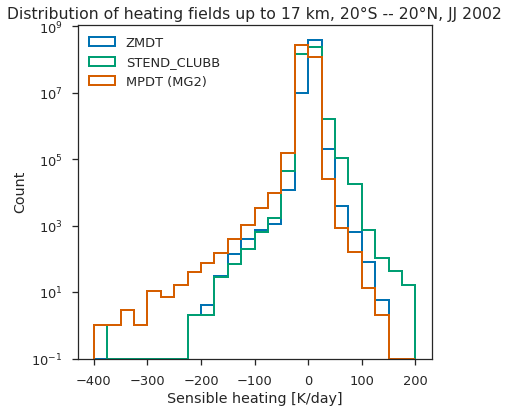

In [6]:
with sns.axes_style('ticks'):
    bins = np.arange(-400, 225, 25)    # from above
    f, ax = plt.subplots(figsize=(7, 6))
    zmdt.plot.hist(ax=ax, bins=bins, log=True, histtype='step', linewidth=2, label='ZMDT')
    cldt.plot.hist(ax=ax, bins=bins, log=True, histtype='step', linewidth=2, label='STEND_CLUBB')
    mpdt.plot.hist(ax=ax, bins=bins, log=True, histtype='step', linewidth=2, label='MPDT (MG2)')

    ax.legend(loc='upper left')
    ax.set_xlabel('Sensible heating [K/day]')
    ax.set_title('Distribution of heating fields up to %d km, 20' % (max_z) + u'\N{DEGREE SIGN}' + 'S -- 20' + u'\N{DEGREE SIGN}' + 'N, JJ 2002')

    plt.tight_layout()
    f.savefig('../figures/heating/dist_1D.png')

#### 2-dimension
To begin recreating rain-rate binned profiles of heating. Through exploration I discovered that shown extrema do change drastically depending on rain-rate bin width. First, I'll set up the precip bins for the comparison. *Note: establish equal bin width across comparisons or equal number of bins?*

In [7]:
bin_width = 0.5
pc_bins = np.arange(0, pc.max().values, bin_width)
pl_bins = np.arange(0, pl.max().values, bin_width)
pt_bins = np.arange(0, pt.max().values, bin_width)

##### ZMDT
vs. PRECC

In [8]:
zm_pc = (zmdt
         .groupby_bins(pc, pc_bins, labels=pc_bins[1:], include_lowest=False)
         .mean(dim='stacked_time_lat_lon')
        )

/glade/u/home/mcamron/miniconda3/envs/gwdst/lib/python3.6/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


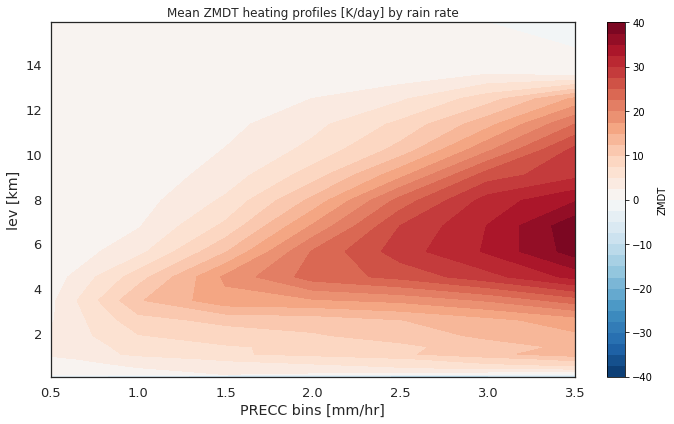

In [9]:
f, ax = plt.subplots(figsize=(10, 6))
p = zm_pc.plot.contourf(ax=ax, levels=40)

ax.set_xlabel('PRECC bins [mm/hr]')
ax.set_ylabel('lev [km]')
ax.set_title('Mean ZMDT heating profiles [K/day] by rain rate')

plt.tight_layout()
f.savefig('../figures/heating/prof_zmdt-precc.png')

vs PRECT

In [10]:
zm_pt = (zmdt
        .groupby_bins(pt, pt_bins, labels=pt_bins[1:], include_lowest=False)
        .mean(dim='stacked_time_lat_lon')
        )

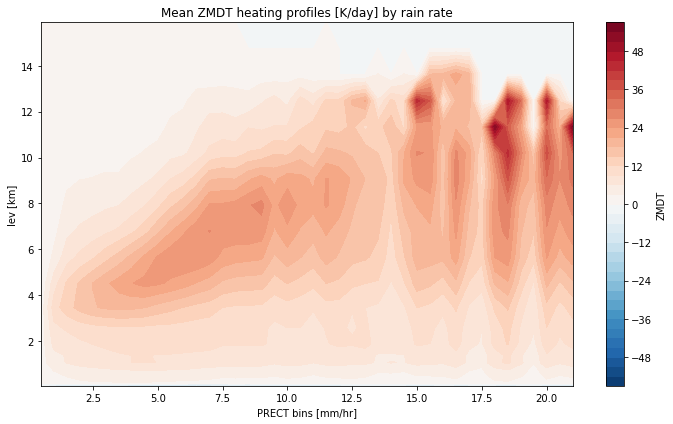

In [11]:
f, ax = plt.subplots(figsize=(10, 6))
p = zm_pt.plot.contourf(ax=ax, levels=40)

ax.set_xlabel('PRECT bins [mm/hr]')
ax.set_ylabel('lev [km]')
ax.set_title('Mean ZMDT heating profiles [K/day] by rain rate')

plt.tight_layout()
f.savefig('../figures/heating/prof_zmdt-prect.png')

##### STEND_CLUBB
vs. PRECL

In [12]:
cl_pl = (cldt
        .groupby_bins(pl, pl_bins, labels=pl_bins[1:], include_lowest=False)
        .mean(dim='stacked_time_lat_lon')
        )

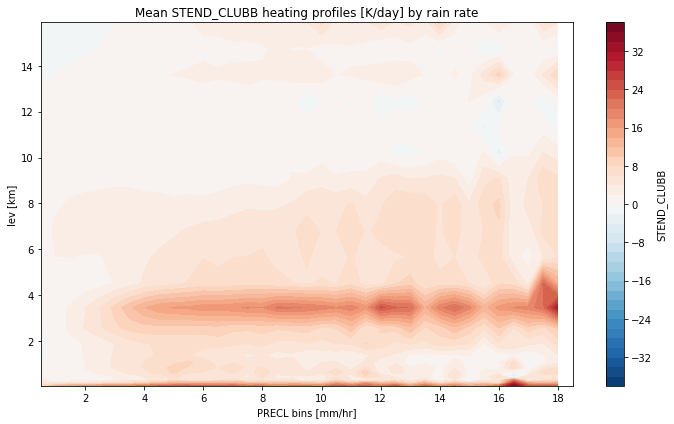

In [13]:
f, ax = plt.subplots(figsize=(10, 6))
p = cl_pl.plot.contourf(ax=ax, levels=40)

ax.set_xlabel('PRECL bins [mm/hr]')
ax.set_ylabel('lev [km]')
ax.set_title('Mean STEND_CLUBB heating profiles [K/day] by rain rate')

plt.tight_layout()
f.savefig('../figures/heating/prof_cldt-precl.png')

vs. PRECT

In [14]:
cl_pt = (cldt
        .groupby_bins(pt, pt_bins, labels=pt_bins[1:], include_lowest=False)
        .mean(dim='stacked_time_lat_lon')
        )

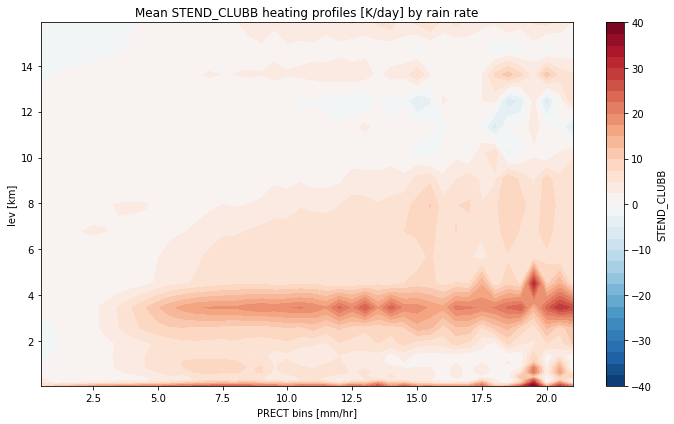

In [15]:
f, ax = plt.subplots(figsize=(10, 6))
p = cl_pt.plot.contourf(ax=ax, levels=40)

ax.set_xlabel('PRECT bins [mm/hr]')
ax.set_ylabel('lev [km]')
ax.set_title('Mean STEND_CLUBB heating profiles [K/day] by rain rate')

plt.tight_layout()
f.savefig('../figures/heating/prof_cldt-prect.png')

##### MPDT
vs. PRECL

In [16]:
mp_pl = (mpdt
        .groupby_bins(pl, pl_bins, labels=pl_bins[1:], include_lowest=False)
        .mean(dim='stacked_time_lat_lon')
        )

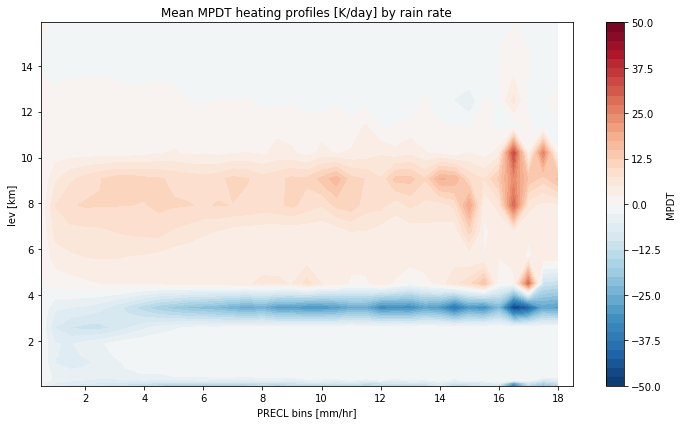

In [17]:
f, ax = plt.subplots(figsize=(10, 6))
p = mp_pl.plot.contourf(ax=ax, levels=40)

ax.set_xlabel('PRECL bins [mm/hr]')
ax.set_ylabel('lev [km]')
ax.set_title('Mean MPDT heating profiles [K/day] by rain rate')

plt.tight_layout()
f.savefig('../figures/heating/prof_mpdt-precl.png')

vs. PRECT

In [18]:
mp_pt = (mpdt
        .groupby_bins(pt, pt_bins, labels=pt_bins[1:], include_lowest=False)
        .mean(dim='stacked_time_lat_lon')
        )

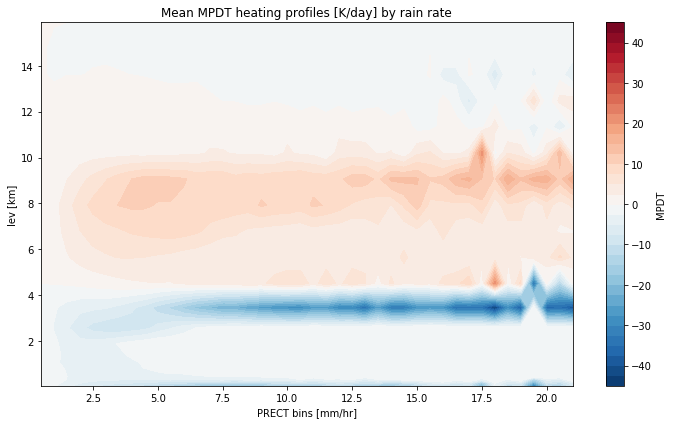

In [19]:
f, ax = plt.subplots(figsize=(10, 6))
p = mp_pt.plot.contourf(ax=ax, levels=40)

ax.set_xlabel('PRECT bins [mm/hr]')
ax.set_ylabel('lev [km]')
ax.set_title('Mean MPDT heating profiles [K/day] by rain rate')

plt.tight_layout()
f.savefig('../figures/heating/prof_mpdt-prect.png')

##### ZMPT and MPPT with CLUBB contours

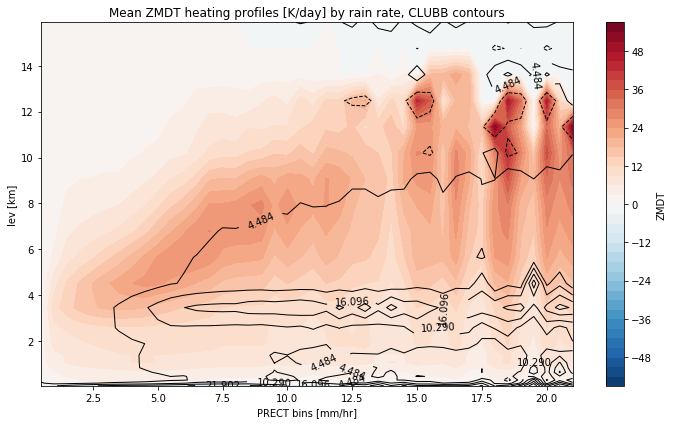

In [20]:
f, ax = plt.subplots(figsize=(10, 6))
levels = np.linspace(cl_pt.min().values, cl_pt.max().values, 9)
p = zm_pt.plot.contourf(ax=ax, levels=40)
q = cl_pt.plot.contour(ax=ax, colors='k', levels=levels, linewidths=1,
                      linestyles=[n for l in [['dashed' for l in levels if float(l) < 0], ['solid' for l in levels if float(l) > 0]] for n in l][1:-1])

q.clabel()

ax.set_xlabel('PRECT bins [mm/hr]')
ax.set_ylabel('lev [km]')
ax.set_title('Mean ZMDT heating profiles [K/day] by rain rate, CLUBB contours')

plt.tight_layout()
f.savefig('../figures/heating/prof_zmdt-prect_clubb.png')

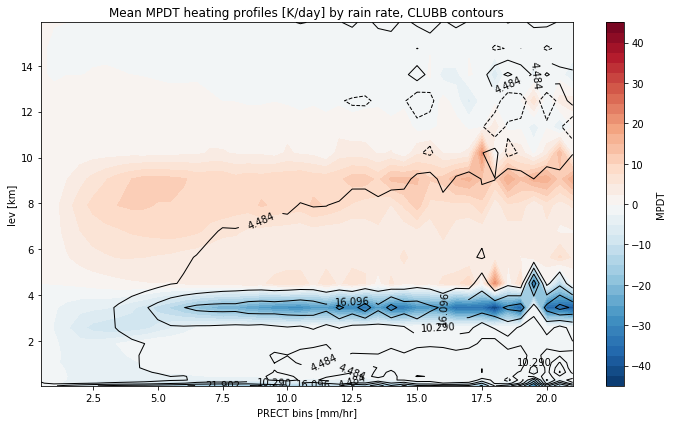

In [21]:
f, ax = plt.subplots(figsize=(10, 6))
levels = np.linspace(cl_pt.min().values, cl_pt.max().values, 9)
p = mp_pt.plot.contourf(ax=ax, levels=40)
q = cl_pt.plot.contour(ax=ax, colors='k', levels=levels, linewidths=1,
                      linestyles=[n for l in [['dashed' for l in levels if float(l) < 0], ['solid' for l in levels if float(l) > 0]] for n in l][1:-1])

q.clabel()


ax.set_xlabel('PRECT bins [mm/hr]')
ax.set_ylabel('lev [km]')
ax.set_title('Mean MPDT heating profiles [K/day] by rain rate, CLUBB contours')

plt.tight_layout()
f.savefig('../figures/heating/prof_mpdt-prect_clubb.png')

##### CLUBB + MG2
vs. PRECL

In [22]:
clmp = cldt + mpdt
clmp_pl = (clmp
          .groupby_bins(pl, pl_bins, labels=pl_bins[1:], include_lowest=False)
          .mean(dim='stacked_time_lat_lon')
          )

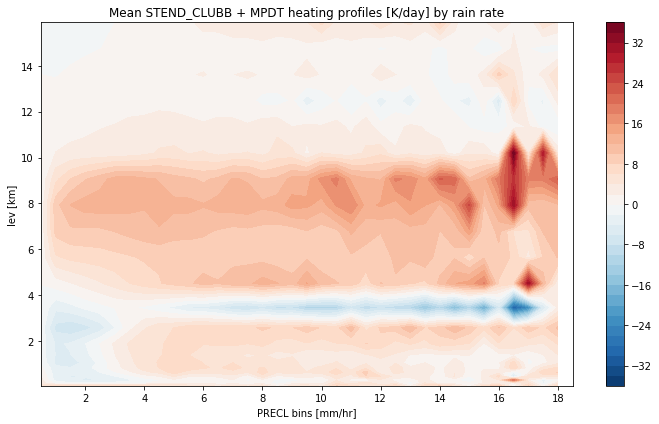

In [23]:
f, ax = plt.subplots(figsize=(10, 6))
p = clmp_pl.plot.contourf(ax=ax, levels=40)

ax.set_xlabel('PRECL bins [mm/hr]')
ax.set_ylabel('lev [km]')
ax.set_title('Mean STEND_CLUBB + MPDT heating profiles [K/day] by rain rate')

plt.tight_layout()
f.savefig('../figures/heating/prof_clmp-precl.png')

vs. PRECT

In [24]:
clmp_pt = (clmp
          .groupby_bins(pt, pt_bins, labels=pt_bins[1:], include_lowest=False)
          .mean(dim='stacked_time_lat_lon')
          
          )

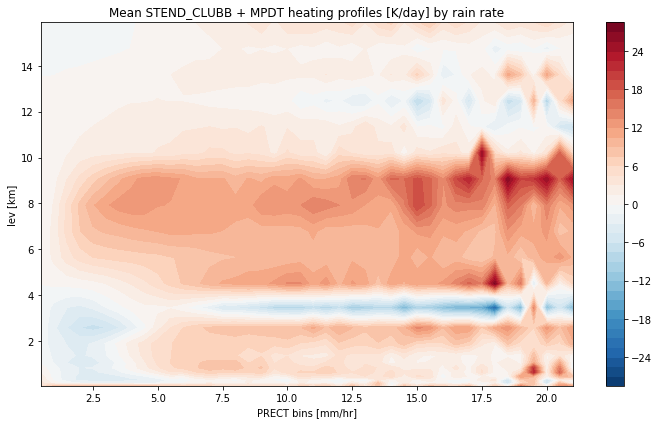

In [25]:
f, ax = plt.subplots(figsize=(10, 6))
p = clmp_pt.plot.contourf(ax=ax, levels=40)

ax.set_xlabel('PRECT bins [mm/hr]')
ax.set_ylabel('lev [km]')
ax.set_title('Mean STEND_CLUBB + MPDT heating profiles [K/day] by rain rate')

plt.tight_layout()
f.savefig('../figures/heating/prof_clmp-prect.png')

##### ZMDT + CLUBB + MG2
vs. PRECT

In [26]:
zmclmp = zmdt + cldt + mpdt
zmclmp_pt = (zmclmp
             .groupby_bins(pt, pt_bins, labels=pt_bins[1:], include_lowest=False)
             .mean(dim='stacked_time_lat_lon')
            )

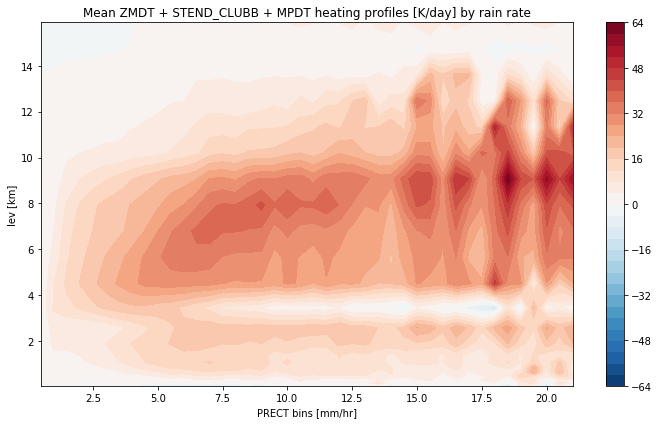

In [27]:
f, ax = plt.subplots(figsize=(10, 6))
p = zmclmp_pt.plot.contourf(ax=ax, levels=40)

ax.set_xlabel('PRECT bins [mm/hr]')
ax.set_ylabel('lev [km]')
ax.set_title('Mean ZMDT + STEND_CLUBB + MPDT heating profiles [K/day] by rain rate')

plt.tight_layout()
f.savefig('../figures/heating/prof_zmclmp-prect.png')